[UMAP](https://umap-learn.readthedocs.io/en/latest/#) is a dimensionality reduction technique. In this notebook I will show how to apply it to the features extracted by an EfficientNet-b0 model.
This allows us to:
* See if the model is able to separate classes. In other words see if it learned anything good.
* Find outliers and clusters among images.
* Check on which images our model makes mistakes.

[Bokeh](https://docs.bokeh.org/en/latest/index.html) is a Python library for interactive visualizations. Static 2D pictures are nice, but have you every wanted to hover over a dot and see what picture corresponds to it?
I aim to reduce the features extracted by the CNN to 2 dimensions, plot all the points along these 2 dimensions.
* Each dot is colored according to image label.
* A dot replaced by a cross if the model made an error on this image.
* Howering over a dot displays a tooltip with the image thumbnail and detailed information.


I will not be aiming for a good model here, just a basic one to demonstrate the visualization. You can apply with your own models!

# What the result will look like:

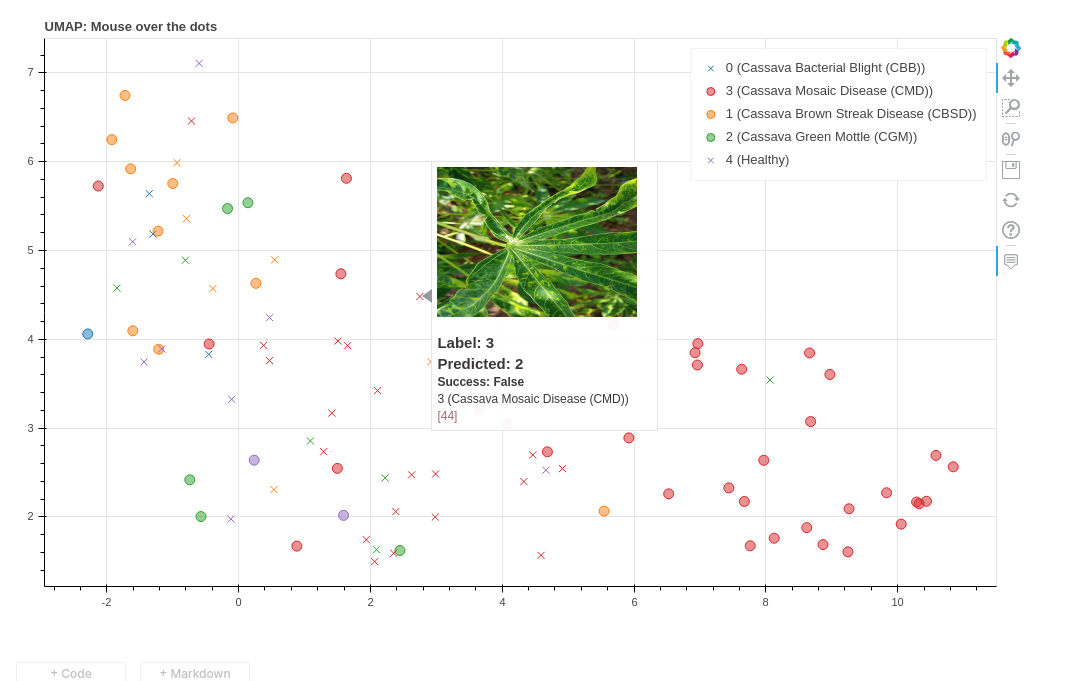

# Installs, imports and utils

In [ ]:
!pip install umap-learn
!pip install bokeh
!pip install timm

In [ ]:
import copy
import os
import numpy as np
import pandas as pd
import torch
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import seaborn as sns
from tqdm.auto import tqdm
from skimage import io
from umap import UMAP

from bokeh.plotting import ColumnDataSource, figure, output_file, show, output_notebook
from bokeh.transform import factor_cmap, factor_mark
from bokeh.palettes import Category10

from pytorch_lightning.metrics.functional import accuracy
from torch import nn
import timm
import pytorch_lightning as pl
from pytorch_lightning import Trainer
import torch.nn.functional as F
from argparse import Namespace

from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

import base64
from io import BytesIO
from skimage import io, filters, measure, morphology, img_as_ubyte
from matplotlib import cm

%matplotlib inline
output_notebook()

In [ ]:
class CassavaDataset(Dataset):
    def __init__(self, root, image_ids, labels, transform=None):
        super().__init__()
        self.root = root
        self.image_ids = image_ids
        self.labels = labels
        self.targets = self.labels
        self.transform = transform

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = io.imread(os.path.join(self.root, self.image_ids[idx]))

        if self.transform:
            img = self.transform(img)

        return img, label

In [ ]:
class LeafDoctorModel(pl.LightningModule):
    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams or Namespace()
        self.trunk = timm.create_model('efficientnet_b0', pretrained=True, num_classes=5)

    def forward(self, x):
        return self.trunk(x)

    def predict_proba(self, x):
        probabilities = nn.functional.softmax(self.forward(x), dim=1)
        return probabilities

    def predict(self, x):
        return torch.max(self.forward(x), 1)[1]

    def configure_optimizers(self):
        trainable_params = list(filter(lambda p: p.requires_grad, self.parameters()))
        optimizer = torch.optim.AdamW(trainable_params,
                                      lr=self.hparams.lr,
                                      weight_decay=self.hparams.weight_decay)

        return optimizer

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = accuracy(y_hat, y)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_loss", loss, on_step=True, on_epoch=False, prog_bar=False, logger=True)
        return loss

In [ ]:
def get_wrapper(transforms):
    def wraps(img):
        return transforms(image=np.array(img))['image']
    return wraps

def get_train_transforms(width, height):
    train_transforms = A.Compose([
        A.RandomResizedCrop(width, height, scale=(0.1, 0.8)),
        A.ToFloat(max_value=1.0),
        A.ShiftScaleRotate(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        A.CoarseDropout(p=0.5),
        A.Cutout(p=0.5),
        ToTensorV2(),
    ])

    return get_wrapper(train_transforms)


def get_test_transforms(width, height):
    test_transforms = A.Compose([
        A.ToFloat(max_value=1.0),
        A.CenterCrop(width, height),
        A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ToTensorV2(),
    ])

    return get_wrapper(test_transforms)

# Train a small CNN

In [ ]:
train_csv = pd.read_csv('../input/cassava-leaf-disease-classification/train.csv')
dataset = CassavaDataset(root='../input/cassava-leaf-disease-classification/train_images', image_ids=train_csv.image_id.values, labels=train_csv.label.values)

In [ ]:
parameters = dict(
    max_epochs=10,
    batch_size=32,
    data_loader_workers=4,
    
    lr=0.001,
    weight_decay=0.0001,
    
    train_width=256,
    train_height=256,
    test_width=300,
    test_height=300,
    
    gpus=-1,
    precision=16,
    amp_level='02'
)

In [ ]:
hparams = Namespace(**parameters)

In [ ]:
model = LeafDoctorModel(hparams)

In [ ]:
train_transform = get_train_transforms(parameters['train_width'], parameters['train_height'])

dataset.transform = train_transform

train_loader = DataLoader(dataset,
                            batch_size=parameters['batch_size'],
                            num_workers=parameters['data_loader_workers'],
                            shuffle=True,
                            pin_memory=True)

In [ ]:
trainer = Trainer.from_argparse_args(
        hparams,
        reload_dataloaders_every_epoch=True,
        terminate_on_nan=True,
        precision=hparams.precision,
        amp_level=hparams.amp_level,
)


trainer.fit(model, train_loader)

# Obtain feature vectors for all training images

In [ ]:
model = model.to('cuda')

extractor = LeafDoctorModel(hparams)
extractor.load_state_dict(model.state_dict())
extractor = extractor.eval().to('cuda')
extractor.trunk.classifier = nn.Identity()

In [ ]:
dataset.transform = get_test_transforms(parameters['test_width'], parameters['test_height'])
loader = torch.utils.data.DataLoader(dataset, batch_size=20, num_workers=4)

In [ ]:
vectors = []
labels = []
predictions = []
for batch in tqdm(loader): 
    images, batch_labels = batch
    images = images.to('cuda')
    predictions += model.predict(images).tolist()
    
    vectors += extractor(images).tolist()
    labels += batch_labels.tolist()
            
predictions = np.array(predictions)
labels = np.array(labels)
success = np.equal(predictions, labels)

In [ ]:
print('Train accuracy', sum(success)/len(success))

# Reduce dimensionality using UMAP

In [ ]:
reducer = UMAP(random_state=42)
transformed = reducer.fit_transform(vectors)
tr_x, tr_y = transformed[:, 0], transformed[:, 1]

# Static visualizations

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=tr_x, y=tr_y, hue=np.array(labels), palette="deep")
plt.axis('off')
plt.title('UMAP of NN extracted features by class')
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
sns.scatterplot(x=tr_x, y=tr_y, hue=success, palette="deep")
plt.axis('off')
plt.title('UMAP of NN extracted features by succesful classification')
plt.show()

# Bokeh to go interactive

In [ ]:
label_num_to_disease_map = {0: "Cassava Bacterial Blight (CBB)", 
                            1: "Cassava Brown Streak Disease (CBSD)", 
                            2: "Cassava Green Mottle (CGM)", 
                            3: "Cassava Mosaic Disease (CMD)", 
                            4: "Healthy"}

In [ ]:
base_dir = '../input/cassava-leaf-disease-classification/train_images'
img_paths = [os.path.join(os.getcwd(), base_dir, img_id) for img_id in dataset.image_ids]
descs = [f'{l.item()} ({label_num_to_disease_map[l.item()]})' for l in labels]

Bokeh requires image urls to display pictures. But we can not display pictures from disk in a kaggle kernel. I encode pictures into base64 urls, so that we can display an interactive visualization.

If you are running this on local computer, it will be much faster to just use `img_paths` in place of `img_urls` below, to render pictures from disk. If you do this, the base64 encoding code could be removed.

In [ ]:
# Source: https://github.com/jni/blob-explorer/blob/master/picker.py#L119
def to_png(arr):
    out = BytesIO()
    im = Image.fromarray(arr)
    im.save(out, format='png')
    return out.getvalue()

def b64_image_files(images, colormap='magma'):
    cmap = cm.get_cmap(colormap)
    urls = []
    for im in tqdm(images):
        #png = to_png(img_as_ubyte(cmap(im)))
        png = to_png(im)
        url = 'data:image/png;base64,' + base64.b64encode(png).decode('utf-8')
        urls.append(url)
    return urls

In [ ]:
def images_generator(dataset):
    for i in list(range(len(dataset))):
        img = dataset[i][0]
        yield np.array(img)

In [ ]:
dataset.transform = None

In [ ]:
image_urls = b64_image_files(images_generator(dataset))

In [ ]:
source = ColumnDataSource(data=dict(
    x=tr_x,
    y=tr_y,
    label=[str(l) for l in labels],
    prediction=[str(p) for p in predictions],
    success=[str(s) for s in success],
    desc=descs,
    imgs=img_paths,
    image_urls=image_urls,
))

In [ ]:
TOOLTIPS = """
    <div>
        <div>
            <img
                src="@image_urls" height="200" alt="@image_urls" width="200"
                style="float: left; margin: 0px 15px 15px 0px;"
                border="2"
            ></img>
        </div>
        <div>
            <div style="font-size: 15px; font-weight: bold;">Label: @label</div>
            <div style="font-size: 15px; font-weight: bold;">Predicted: @prediction</div>
            <div style="font-size: 12px; font-weight: bold;">Success: @success</div>
            <div style="font-size: 12px;">@desc</div>
            <div style="font-size: 12px; color: #966;">[$index]</div>
        </div>
    </div5
"""

In [ ]:
p = figure(plot_width=1000, plot_height=600, tooltips=TOOLTIPS,
           title="UMAP: Mouse over the dots")

mapper = factor_cmap(field_name='label', palette=Category10[5], factors=['0', '1', '2', '3', '4'])

p.scatter('x', 'y', 
         color=mapper,
         marker=factor_mark('success', ['circle', 'x'], [str(True), str(False)]),
         size=10, 
         fill_alpha=0.5,
         legend_field="desc",
         source=source)

p.legend.orientation = "vertical"
p.legend.location = "top_right"
output_file("umap.html")
show(p)

### Done! Hope you found this useful!

You can also download `umap.html` to analyze locally.